<a href="https://colab.research.google.com/github/guevelel/COMP4449_Image_Classification/blob/main/P7_Plume_COMP4449.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP4449 Final - Term Project 7: Mystery at the Wildlife Preserve (Plume Analysis)
## Edward Guevel


####Goals

1- Characterize the sensors’ performance and operation. Are they all working properly at all times? Can you detect any unexpected behaviors of the sensors through analyzing the readings they capture?

2- Now turn your attention to the chemicals themselves. Which chemicals are being detected by the sensor group? What patterns of chemical releases do you see, as being reported in the data?

3- Which factories are responsible for which chemical releases? Carefully describe how you determined this using all the data you have available. For the factories you identified, describe any observed patterns of operation revealed in the data.

In [115]:
#QUESTIONS:
#Does time of day matter, month to month, wind speed v. sensor
#Boxplots for sensor data to find outliers?

#Note meteorigical data is not always working, there are some missing dates? isin?
#Remove the sensor data that does not have an associated windspeed!
#Plot wind speed v. date?
#Revisit wind direction and sensor data not aligning on dates...
#
#Wind sensor is backwards... (North is South)
#STRUGGLING WITH USING REGRESSION TO DO ANYTHING?
#STRUGGLING WITH WHAT TO DO WITH HIGH SENSOR VALUES? Normalize or standardize help?
#WILL BREAKING OUT MONTH TO MONTH HELP??

#Regression of different wind speeds and directions and the sensor readings
#Factory is delivering toxic, they could be tampering with the sensors???
#Times during the day or during the night? (sensor tampering) - is something odd going on?
#PPM could be high or low? How do you decide to treat outliers (treat as errors, or treat as high reading)
#

In [116]:
!pip3 install dash --upgrade
!pip install jupyter-dash --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
#Import required libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

import plotly.express as px
import plotly.io as pio
from dash import Dash
from dash import dcc, html
from dash import Input, Output
from jupyter_dash import JupyterDash
pio.renderers.default = "notebook_connected"


from google.colab import files
import io

In [118]:
#Upload files from computer:

uploaded = files.upload()

Saving SensorData.csv to SensorData (2).csv
Saving MeteorologicalData.csv to MeteorologicalData (2).csv


In [119]:
#Write files to pandas DF:
meteor = pd.read_csv('MeteorologicalData.csv')
#meteor = pd.read_csv(io.BytesIO(uploaded['MeteorologicalData.xlsx']))
sensor = pd.read_csv('SensorData.csv')

In [120]:
meteor.head()
#meteor.describe()

,Date,Wind Direction,Wind Speed (m/s),Unnamed: 3,Unnamed: 4
0,4/1/16 0:00,190.5,4.0,NaN,NaN
1,4/1/16 3:00,203.3,5.0,NaN,NaN
2,4/1/16 6:00,201.1,5.2,NaN,NaN
3,4/1/16 9:00,204.9,4.1,NaN,NaN
4,4/1/16 12:00,207.0,3.6,NaN,NaN


In [121]:
sensor.head()
sensor

,Chemical,Monitor,Date Time,Reading
0,Methylosmolene,3,4/1/16 0:00,2.683820
1,Methylosmolene,7,4/1/16 0:00,2.630640
2,Chlorodinine,3,4/1/16 0:00,1.259170
3,Chlorodinine,7,4/1/16 0:00,0.943983
4,AGOC-3A,3,4/1/16 0:00,0.722303
...,...,...,...,...
79238,AGOC-3A,1,12/31/16 23:00,0.078266
79239,Methylosmolene,3,12/31/16 23:00,0.062784
79240,AGOC-3A,2,12/31/16 23:00,0.060814
79241,Appluimonia,7,12/31/16 23:00,0.039729


In [122]:
#meteor['Unnamed: 3'].values.sum()
meteor.drop(columns=['Unnamed: 3', 'Unnamed: 4'], inplace=True)
#sensor = sensor.rename(columns={'Date Time ': 'date'}, inplace=True)
sensor.rename(columns = {'Date Time ': 'date'}, inplace=True)

#meteor.head()
#sensor.head()

In [123]:
#sns.pairplot(sensor)

In [124]:
#Create list of sensor coordinates:
sensor_coords = {1:[62,21],2:[66,35],3:[76,41],
                 4:[88,45],5:[103,43], 6:[102,22],
                 7:[89,3],8:[74,7],9:[119,42]}

#Append sensor_coords to sensor dataframe:
def add_x_coords(row):
  return sensor_coords[row['Monitor']][0]
def add_y_coords(row):
  return sensor_coords[row['Monitor']][1]
  
sensor['x'] = sensor.apply(lambda row: add_x_coords(row), axis=1)
sensor['y'] = sensor.apply(lambda row: add_y_coords(row), axis=1)

sensor.head()

,Chemical,Monitor,date,Reading,x,y
0,Methylosmolene,3,4/1/16 0:00,2.683820,76,41
1,Methylosmolene,7,4/1/16 0:00,2.630640,89,3
2,Chlorodinine,3,4/1/16 0:00,1.259170,76,41
3,Chlorodinine,7,4/1/16 0:00,0.943983,89,3
4,AGOC-3A,3,4/1/16 0:00,0.722303,76,41


In [125]:
#Check for missing values:
#sensor.isnull().sum()
meteor.isnull().sum()

#Drop null values from Meteorological Data, since so few values:
meteor.dropna(axis=0, inplace=True)
meteor.isnull().sum()


Date                0
Wind Direction      0
Wind Speed (m/s)    0
dtype: int64

In [126]:
#Convert string dates to date-time objects:
sensor['date'] = pd.to_datetime(sensor['date'], format="%m/%d/%y %H:%M")

meteor['Date'] = pd.to_datetime(meteor['Date'] , format="%m/%d/%y %H:%M")

sensor.head()

,Chemical,Monitor,date,Reading,x,y
0,Methylosmolene,3,2016-04-01,2.683820,76,41
1,Methylosmolene,7,2016-04-01,2.630640,89,3
2,Chlorodinine,3,2016-04-01,1.259170,76,41
3,Chlorodinine,7,2016-04-01,0.943983,89,3
4,AGOC-3A,3,2016-04-01,0.722303,76,41


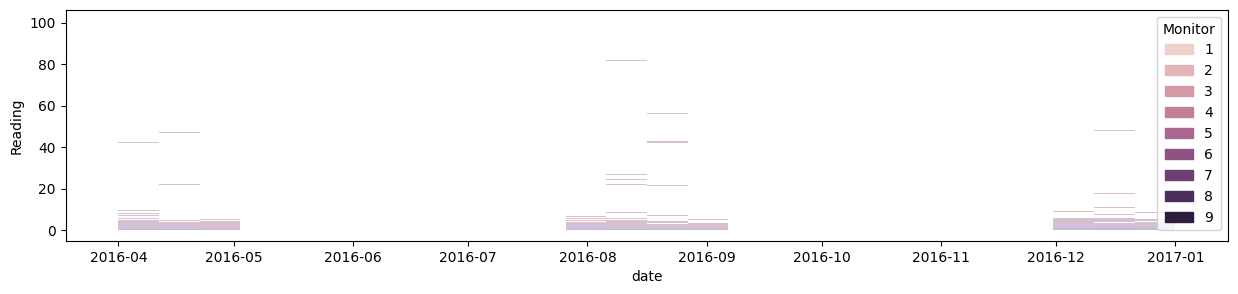

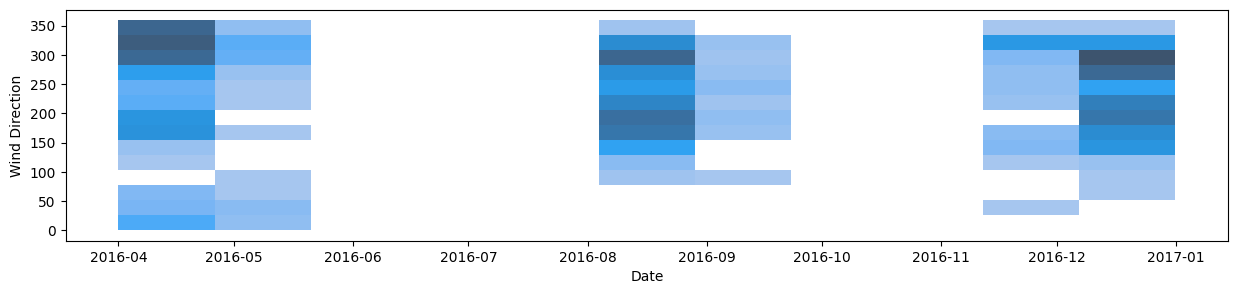

In [127]:
#Histogram of the sensor data:
plt.figure(figsize=(15,3))
sns.histplot(sensor, y=sensor['Reading'], x=sensor['date'], hue=sensor['Monitor'])
#sns.scatter
plt.show()

#Histogram of the Meteorological data:
plt.figure(figsize=(15,3))
sns.histplot(meteor, y=meteor['Wind Direction'], x=meteor['Date'])
#sns.scatter
plt.show()

In [128]:
#Add wind direction and speed as columns to sensor data:

meteor_dates = meteor['Date'].tolist()

def add_wind(row):
  if row['date'] in meteor_dates:
    return meteor.loc[meteor['Date'] == row['date']]['Wind Direction'].tolist()[0]
  else:
    if row['date'] - timedelta(hours=1) in meteor_dates:
      return meteor.loc[meteor['Date'] == (row['date']- timedelta(hours=1))]['Wind Direction'].tolist()[0]
    if row['date'] - timedelta(hours=2) in meteor_dates:
      return meteor.loc[meteor['Date'] == (row['date']- timedelta(hours=2))]['Wind Direction'].tolist()[0]

def add_windspeed(row):
  if row['date'] in meteor_dates:
    return meteor.loc[meteor['Date'] == row['date']]['Wind Speed (m/s)'].tolist()[0]
  else:
    if row['date'] - timedelta(hours=1) in meteor_dates:
      return meteor.loc[meteor['Date'] == (row['date']- timedelta(hours=1))]['Wind Speed (m/s)'].tolist()[0]
    if row['date'] - timedelta(hours=2) in meteor_dates:
      return meteor.loc[meteor['Date'] == (row['date']- timedelta(hours=2))]['Wind Speed (m/s)'].tolist()[0]
 
sensor['wind'] = sensor.apply(lambda row: add_wind(row), axis=1)
sensor['wind_speed'] = sensor.apply(lambda row: add_windspeed(row), axis=1)
sensor.sample(10)



,Chemical,Monitor,date,Reading,x,y,wind,wind_speed
74305,AGOC-3A,6,2016-12-26 06:00:00,0.110553,102,22,345.9,0.5
27751,Methylosmolene,5,2016-08-03 05:00:00,0.101211,103,43,NaN,NaN
25710,AGOC-3A,1,2016-04-30 20:00:00,0.420459,62,21,324.3,1.5
45555,Chlorodinine,6,2016-08-23 22:00:00,0.640361,102,22,243.3,3.2
9324,Appluimonia,3,2016-04-11 21:00:00,0.944572,76,41,172.9,2.6
50038,Appluimonia,1,2016-08-29 02:00:00,0.065222,62,21,178.2,1.4
44995,Appluimonia,9,2016-08-23 06:00:00,0.145422,119,42,253.8,0.7
34480,Chlorodinine,9,2016-08-11 02:00:00,0.256701,119,42,205.5,1.4
3902,AGOC-3A,6,2016-04-05 13:00:00,0.381607,102,22,347.3,2.5
52176,Methylosmolene,6,2016-08-31 14:00:00,0.740278,102,22,215.1,1.1


<Axes: >

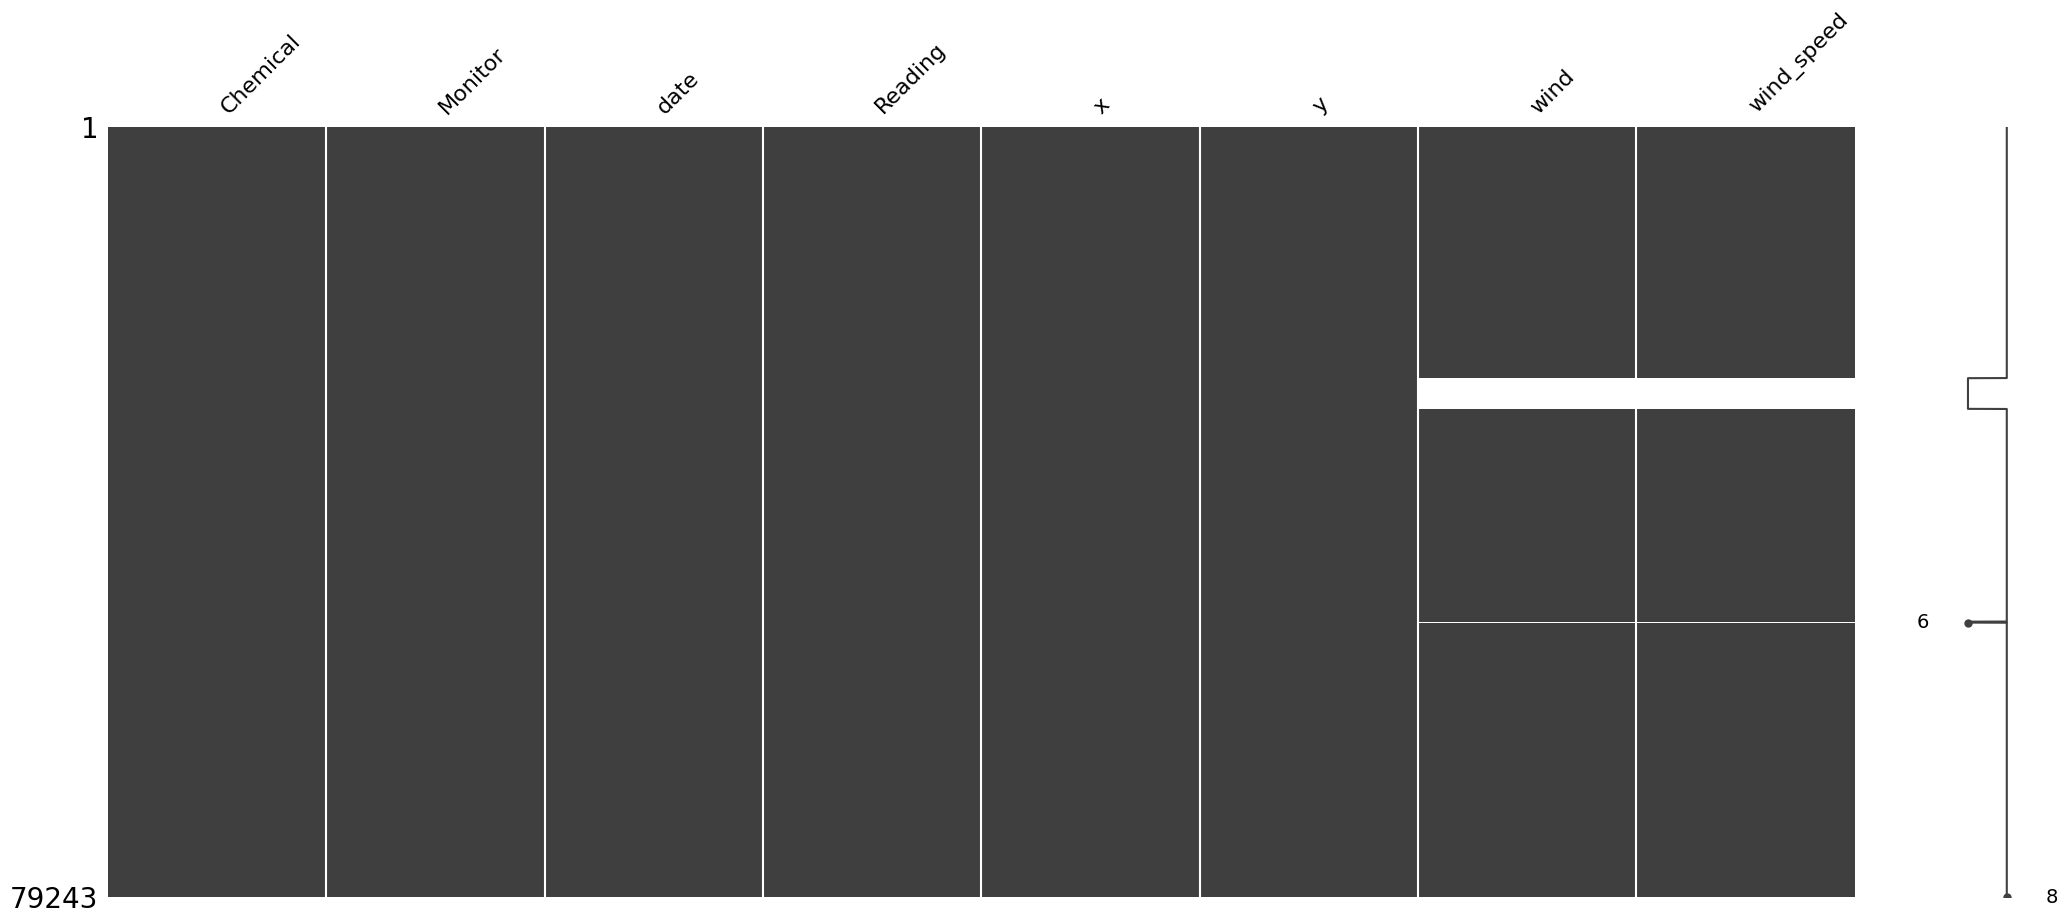

In [129]:
import missingno as msno
msno.matrix(sensor)

Note that the Meteorological Data is missing values at the beginning of August and at the beginning of December. Overall, it is not missing very much data

In [130]:
#

In [131]:
meteor.head(2)#

,Date,Wind Direction,Wind Speed (m/s)
0,2016-04-01 00:00:00,190.5,4.0
1,2016-04-01 03:00:00,203.3,5.0


In [132]:
sensor.head(2)

,Chemical,Monitor,date,Reading,x,y,wind,wind_speed
0,Methylosmolene,3,2016-04-01,2.68382,76,41,190.5,4.0
1,Methylosmolene,7,2016-04-01,2.63064,89,3,190.5,4.0


In [133]:
'''
#Histogram of the sensor data:
plt.figure(figsize=(15,6))
sns.histplot(sensor, y=sensor['Reading'], x=sensor['date'], hue=sensor['Monitor'])
#sns.scatter
plt.show()

#Histogram of the Meteorological data:
plt.figure(figsize=(15,6))
sns.histplot(meteor, y=meteor['Wind Direction'], x=meteor['Date'])
#sns.scatter
plt.show()
'''

"\n#Histogram of the sensor data:\nplt.figure(figsize=(15,6))\nsns.histplot(sensor, y=sensor['Reading'], x=sensor['date'], hue=sensor['Monitor'])\n#sns.scatter\nplt.show()\n\n#Histogram of the Meteorological data:\nplt.figure(figsize=(15,6))\nsns.histplot(meteor, y=meteor['Wind Direction'], x=meteor['Date'])\n#sns.scatter\nplt.show()\n"

In [134]:
#sns.pairplot(sensor)

We can see that the sensors were only collecting data in certain time ranges...

In [135]:
print(f"Null values after merging data: {sensor.isna().sum()}")

#We will drop the null values since 3278 is only 4% of the data set:
sensor.dropna(axis=0, inplace=True)
#sensor.isna().sum()

Null values after merging data: Chemical         0
Monitor          0
date             0
Reading          0
x                0
y                0
wind          3278
wind_speed    3278
dtype: int64


<Axes: xlabel='date', ylabel='Reading'>

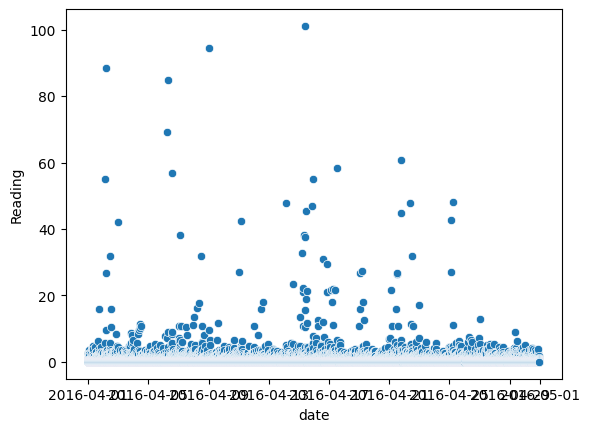

In [136]:
#look at april-may sensor data:


#apr_sensor = sensor.iloc[0:25847]
#oct_sensor = sensor.iloc[25848:52525]
#dec_sensor = sensor.iloc[52526:]

#sns.scatterplot(apr_sensor, x=apr_sensor['date'],y=apr_sensor['Reading'])

#plt.ylim(bottom = .01,top=10)
#plt.show()

In [137]:
#Update headers, labels, and add graphs for the other two sensors
'''
plt.figure(figsize=(15,15))
for i in range(1,10):
  plt.subplot(3,3,i)
  #plt.xticks([])
  #plt.yticks([])
  #plt.grid(False)
  temp = apr_sensor[apr_sensor['Monitor']==i]
  #apr_sensor
  sns.scatterplot(temp, x=temp['date'], y=temp['Reading'], hue=sensor['Monitor'])
  #titles = np.where(train['labels']==i)
  #index = titles[0][50]
  #plt.imshow(train['features'][index], cmap=plt.cm.binary)
  plt.xlabel(f'Sensor {i}')
  plt.xticks(rotation = 90)
plt.show()
'''

"\nplt.figure(figsize=(15,15))\nfor i in range(1,10):\n  plt.subplot(3,3,i)\n  #plt.xticks([])\n  #plt.yticks([])\n  #plt.grid(False)\n  temp = apr_sensor[apr_sensor['Monitor']==i]\n  #apr_sensor\n  sns.scatterplot(temp, x=temp['date'], y=temp['Reading'], hue=sensor['Monitor'])\n  #titles = np.where(train['labels']==i)\n  #index = titles[0][50]\n  #plt.imshow(train['features'][index], cmap=plt.cm.binary)\n  plt.xlabel(f'Sensor {i}')\n  plt.xticks(rotation = 90)\nplt.show()\n"

In [138]:
'''
plt.figure(figsize=(20, 20))
chem_dict = {1:'Chlorodinine', 2:'Methylosmolene', 3:'AGOC-3A', 0:'Appluimonia'}
for i in range(1,37):
  for k in range(1, 5):
    plt.subplot(4,9,i)

    temp = apr_sensor[apr_sensor['Monitor']==i%9+1]
    c = k%4
    temp = temp[temp['Chemical']==chem_dict[c]]
    #apr_sensor
    sns.scatterplot(temp, x=temp['date'], y=temp['Reading'], hue =temp['Monitor'] )
    #titles = np.where(train['labels']==i)
    #index = titles[0][50]
    #plt.imshow(train['features'][index], cmap=plt.cm.binary)
    plt.xlabel(f'Sensor {i%9+1}')
    plt.xticks(rotation = 90)
plt.show()
'''

"\nplt.figure(figsize=(20, 20))\nchem_dict = {1:'Chlorodinine', 2:'Methylosmolene', 3:'AGOC-3A', 0:'Appluimonia'}\nfor i in range(1,37):\n  for k in range(1, 5):\n    plt.subplot(4,9,i)\n\n    temp = apr_sensor[apr_sensor['Monitor']==i%9+1]\n    c = k%4\n    temp = temp[temp['Chemical']==chem_dict[c]]\n    #apr_sensor\n    sns.scatterplot(temp, x=temp['date'], y=temp['Reading'], hue =temp['Monitor'] )\n    #titles = np.where(train['labels']==i)\n    #index = titles[0][50]\n    #plt.imshow(train['features'][index], cmap=plt.cm.binary)\n    plt.xlabel(f'Sensor {i%9+1}')\n    plt.xticks(rotation = 90)\nplt.show()\n"

In [139]:
from statistics import mean, median
sensor.groupby(['Monitor', 'Chemical']).agg({'Reading': [min, max, mean, median]}) #Reading

Reading                               
                             min        max      mean    median
Monitor Chemical                                               
1       AGOC-3A         0.001065   31.66583  0.247551  0.204751
        Appluimonia     0.001130    2.20189  0.234196  0.207819
        Chlorodinine    0.001015    5.09007  0.246517  0.217125
        Methylosmolene  0.001003   31.80997  0.244332  0.206787
2       AGOC-3A         0.001598   26.58683  0.379821  0.297561
        Appluimonia     0.001322    1.80374  0.358014  0.312735
        Chlorodinine    0.001633    7.46014  0.358775  0.303008
        Methylosmolene  0.001591   42.71211  0.391639  0.301542
3       AGOC-3A         0.001257   85.31459  1.604814  1.031770
        Appluimonia     0.001899    6.92741  1.262546  0.979943
        Chlorodinine    0.001661    8.96003  1.287194  1.011125
        Methylosmolene  0.002452   47.74763  1.377328  0.981951
4       AGOC-3A         0.001833   65.71898  1.506940  1.132690
        Appluimonia     0.001054    4.86055  1.136847  1.106710
        Chlorodinine    0.002067   14.58982  1.230909  1.125095
        Methylosmolene  0.001067   38.21998  1.232873  1.117135
5       AGOC-3A         0.001235   84.63599  0.927088  0.358368
        Appluimonia     0.001154    7.74279  0.462172  0.336965
        Chlorodinine    0.001040   11.74958  0.512913  0.329785
        Methylosmolene  0.001876   53.64960  0.550409  0.346014
6       AGOC-3A         0.001187   84.82578  1.329150  0.410961
        Appluimonia     0.003286    8.95095  0.419776  0.398960
        Chlorodinine    0.002921   15.04032  0.687027  0.414594
        Methylosmolene  0.001418  100.77640  0.988030  0.397912
7       AGOC-3A         0.001574   47.05521  0.698610  0.431402
        Appluimonia     0.002178    4.84236  0.603231  0.438515
        Chlorodinine    0.001124   13.40056  0.619989  0.428507
        Methylosmolene  0.001060   63.31599  0.742092  0.411834
8       AGOC-3A         0.001025  101.10558  0.568444  0.435373
        Appluimonia     0.001803    4.87418  0.475398  0.433945
        Chlorodinine    0.001076    7.44058  0.481509  0.418473
        Methylosmolene  0.001448   32.82523  0.494827  0.417768
9       AGOC-3A         0.001790   47.95602  0.715668  0.298013
        Appluimonia     0.001334    8.51651  0.428177  0.297018
        Chlorodinine    0.001216    5.03405  0.373929  0.286737
        Methylosmolene  0.001241   42.51119  0.423995  0.283902

In [140]:
sensor.describe()

,Monitor,Reading,x,y,wind,wind_speed
count,75965.000000,75965.000000,75965.000000,75965.000000,75965.000000,75965.000000
mean,5.000145,0.711955,86.555493,28.776437,236.451238,2.250460
std,2.581990,2.084441,17.839215,15.179378,79.239691,1.283244
min,1.000000,0.001003,62.000000,3.000000,0.100000,0.100000
25%,3.000000,0.192900,74.000000,21.000000,182.500000,1.200000
50%,5.000000,0.394688,88.000000,35.000000,251.800000,2.200000
75%,7.000000,0.748538,102.000000,42.000000,299.900000,3.100000
max,9.000000,101.105580,119.000000,45.000000,359.100000,6.800000


In [141]:
#Create DF of factory coordinates:
factories = {'Roadrunner':[89,27], 'Kasios': [90,21], 'Radiance':[109,26], 'Indigo':[120,22]}
fac = pd.DataFrame.from_dict(factories, orient='index')
fac.rename(columns = {0: 'x', 1:'y'}, inplace=True)
fac['Chemical'] =fac.index.tolist()
fac

,x,y,Chemical
Roadrunner,89,27,Roadrunner
Kasios,90,21,Kasios
Radiance,109,26,Radiance
Indigo,120,22,Indigo


In [142]:
#fac.index.tolist()
sensor.head(2)

,Chemical,Monitor,date,Reading,x,y,wind,wind_speed
0,Methylosmolene,3,2016-04-01,2.68382,76,41,190.5,4.0
1,Methylosmolene,7,2016-04-01,2.63064,89,3,190.5,4.0


In [143]:
#Add factories to sensor df for graphical purposes

#Want to add all wind speeds for the factories so they show up in the plotly plots:
for i in range(0, 340, 30):
  sensor_graph = pd.concat([sensor,
                      pd.DataFrame({'Chemical':'Roadrunner', 'Monitor': 20, 'date':'2016-04-01 00:00:00', 'Reading':20, 
                             'x':89,'y':27, 'wind': i, 'wind_speed':1 }, index=[0])], axis=0, ignore_index = True)
  sensor_graph  = pd.concat([sensor_graph ,
                      pd.DataFrame({'Chemical':'Kasios', 'Monitor': 20, 'date':'2016-04-01 00:00:00', 'Reading':20, 
                             'x':90,'y':21, 'wind': i, 'wind_speed':1 }, index=[0])], axis=0, ignore_index = True)
  sensor_graph  = pd.concat([sensor_graph ,
                      pd.DataFrame({'Chemical':'Indigo', 'Monitor': 20, 'date':'2016-04-01 00:00:00', 'Reading':20, 
                             'x':120,'y':22, 'wind': i, 'wind_speed':1 }, index=[0])], axis=0, ignore_index = True)
  sensor_graph  = pd.concat([sensor_graph ,
                      pd.DataFrame({'Chemical':'Radiance', 'Monitor': 20, 'date':'2016-04-01 00:00:00', 'Reading':20, 
                             'x':109,'y':26, 'wind': i, 'wind_speed':1 }, index=[0])], axis=0, ignore_index = True)



In [144]:
sensor_graph.tail()

,Chemical,Monitor,date,Reading,x,y,wind,wind_speed
75964,AGOC-3A,7,2016-12-31 23:00:00,0.014658,89,3,161.0,3.5
75965,Roadrunner,20,2016-04-01 00:00:00,20.000000,89,27,330.0,1.0
75966,Kasios,20,2016-04-01 00:00:00,20.000000,90,21,330.0,1.0
75967,Indigo,20,2016-04-01 00:00:00,20.000000,120,22,330.0,1.0
75968,Radiance,20,2016-04-01 00:00:00,20.000000,109,26,330.0,1.0


In [145]:
app = JupyterDash()

app.layout = html.Div(children = [
    html.Div([
        dcc.Graph(id='graph-with-slider'),
    ]) ,
    html.Div([
        html.H6('Wind Direction'),
        dcc.RangeSlider(
            id='wind_direction-slider',
            min=0,
            max=sensor_graph['wind'].max(),
            step=10,
            value=[sensor_graph['wind'].min(),sensor_graph['wind'].max()])
    ]),
    html.Div([
        html.H6('Wind Speed'),
        dcc.RangeSlider(
            id='wind_speed-slider',
            min=0,
            max=sensor_graph['wind_speed'].max(),
            step=.5,
            value=[sensor_graph['wind_speed'].min(),sensor_graph['wind_speed'].max()])
    ])
])


@app.callback(
    Output(component_id='graph-with-slider', component_property='figure'),
    Input(component_id='wind_direction-slider', component_property='value'),
    Input(component_id='wind_speed-slider', component_property='value'))

def update_figure(selected_wind, selected_speed):
    filtered_df = sensor_graph[(sensor_graph.wind >= selected_wind[0])&
                              (sensor_graph.wind <= selected_wind[1])&
                               (sensor_graph.wind_speed >= selected_speed[0])&
                               (sensor_graph.wind_speed <= selected_speed[1])]
    fig = px.scatter(filtered_df, x="x", y="y",
                 size="Reading", color="Chemical", hover_name="Chemical",
                 size_max=20, color_discrete_map={'Appluimonia': 'blue', 
                                                   'Chlorodinine': 'red', 
                                                  'Methylosmolene': 'yellow',
                                                  'AGOC-3A': 'green'})
    #color_discrete_sequence=px.colors.qualitative.Antique)
    fig.update_layout(transition_duration=100)
    return fig

app.run_server(mode='inline')

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>

In [146]:
sensor_graph['date'].iloc[-1] > sensor_graph['date'].iloc[-2]
#sensor_graph['date'].tail()
timedelta(hours=3)

datetime.timedelta(seconds=10800)

In [147]:
#d = (list(sensor.date))
#sensor['datestring'] = str(sensor['date'])
#sensor['datestring'] = sensor['date'].apply(lambda x: str(x))
#sensor.head()
sensor.head(10)

,Chemical,Monitor,date,Reading,x,y,wind,wind_speed
0,Methylosmolene,3,2016-04-01,2.683820,76,41,190.5,4.0
1,Methylosmolene,7,2016-04-01,2.630640,89,3,190.5,4.0
2,Chlorodinine,3,2016-04-01,1.259170,76,41,190.5,4.0
3,Chlorodinine,7,2016-04-01,0.943983,89,3,190.5,4.0
4,AGOC-3A,3,2016-04-01,0.722303,76,41,190.5,4.0
5,Appluimonia,2,2016-04-01,0.518521,66,35,190.5,4.0
6,Appluimonia,8,2016-04-01,0.502186,74,7,190.5,4.0
7,AGOC-3A,7,2016-04-01,0.497282,89,3,190.5,4.0
8,Appluimonia,6,2016-04-01,0.458144,102,22,190.5,4.0
9,Methylosmolene,8,2016-04-01,0.456104,74,7,190.5,4.0


In [148]:
#sensor['datestring'][300]#<=sensor['datestring'][40000]
#sensor[0:10]
#sensor.iloc[0].date >= sensor['date'][2]

In [149]:
#sensor['datenum'] = [x for x in range(len(sensor['date'].unique()))]
#sensor['date'].apply(lambda x: str(x))
#sensor['date'].unique()

#Assign all dates to a numerical value:
l = list(sensor['date'].unique())
sensor['datenum']  = sensor['date'].apply(lambda x: l.index(x) )
  
#list(sensor['date'].unique()).index('2016-04-01T01:00:00.000000000')
sensor.sample(10)

,Chemical,Monitor,date,Reading,x,y,wind,wind_speed,datenum
53238,AGOC-3A,1,2016-12-01 19:00:00,0.303428,62,21,246.4,1.8,1387
55056,Appluimonia,6,2016-12-03 23:00:00,0.859015,102,22,314.7,3.7,1438
46296,AGOC-3A,3,2016-08-24 18:00:00,0.031009,76,41,237.1,2.6,1197
77091,Appluimonia,5,2016-12-29 12:00:00,1.384270,103,43,138.8,2.8,2051
2466,Methylosmolene,9,2016-04-03 21:00:00,0.335124,119,42,296.4,5.6,68
32389,Appluimonia,6,2016-08-08 16:00:00,0.270814,102,22,279.8,3.9,811
21853,Chlorodinine,7,2016-04-26 09:00:00,1.436380,89,3,26.9,0.3,607
60620,Methylosmolene,9,2016-12-10 10:00:00,0.251677,119,42,308.8,3.4,1593
58122,AGOC-3A,7,2016-12-07 13:00:00,0.767529,89,3,144.5,1.2,1524
12868,AGOC-3A,3,2016-04-15 23:00:00,0.370188,76,41,10.7,2.8,357


In [150]:
#sensor['Reading'].unique()

In [151]:
#Plots for Reading v. Date:

app = JupyterDash()

app.layout = html.Div(children = [
    html.Div([
        dcc.Graph(id='graph-with-slider'),
    ]) ,
    html.Div([
            dcc.Checklist(
                [1,2,3,4,5,6,7,8,9],
                [1],
                id='monitor-selection',
                inline=True
            ),
            dcc.Checklist(
                ['Appluimonia', 'Chlorodinine', 'Methylosmolene', 'AGOC-3A'],
                ['Appluimonia'],
                id='chemical-type',
                inline=True
            )
        ], style={'width': '48%', 'display': 'inline-block'}),
    html.Div([
        html.H6('Wind Direction'),
        dcc.RangeSlider(
            id='wind_direction-slider',
            min=0,
            max=sensor['wind'].max(),
            step=10,
            value=[sensor['wind'].min(),sensor['wind'].max()])
    ]),
    html.Div([
        html.H6('Date Range'),
        dcc.RangeSlider(
            id='date-slider',
            #min=0,
            min = sensor['datenum'].min(),
            #max=d[-1],
            max=sensor['datenum'].max(),
            step=10,
            #value=[sensor_graph['wind'].min(),sensor_graph['wind'].max()])
            #value=[0,d[-1]])
            value=[sensor['datenum'].min(),sensor['datenum'].max()])
    ]),
])
@app.callback(
    Output(component_id='graph-with-slider', component_property='figure'),
    Input(component_id='date-slider', component_property='value'),
    Input(component_id='monitor-selection', component_property='value'),
    Input(component_id='chemical-type', component_property='value'),
    Input(component_id='wind_direction-slider', component_property='value')
)

def update_figure(selected_date, selected_monitor, selected_chemicals, selected_wind):

    filtered_df = sensor[(sensor.datenum >= selected_date[0]) & (sensor.datenum <= selected_date[1]) & 
                         (sensor.Monitor.isin(selected_monitor)) & (sensor.Chemical.isin(selected_chemicals)) &
                         (sensor_graph.wind >= selected_wind[0])& (sensor_graph.wind <= selected_wind[1])]

    fig = px.scatter(filtered_df, x="date", y="Reading", color='Chemical',
                     color_discrete_map={'Appluimonia': 'blue', 
                                         'Chlorodinine': 'red',
                                         'Methylosmolene': 'yellow',
                                         'AGOC-3A': 'green'})

    fig.update_layout(transition_duration=100)
    #fig.update_xaxes(rangeslider_visible=True)

    return fig

app.run_server(mode='inline')

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>

Narrowing in the date range above, when all Sensors and Chemicals are selected, allows us to pinpoint the irregularities in the sensor data. We can see that there are at least 7 time ranges where the sensors did not record data. I also added the wind directions at those times.

Blackout Dates & Times:

April 2nd: 0:00, Wind Drection: 262.3, Wind Speed: 2.9

April 6th: 0:00, Wind Drection: 307.1, Wind Speed: 2.3

April 29th: 6:00, Wind Drection: 359.1, Wind Speed: 0.4

August 7th: 0:00, Wind Drection: 287.7, Wind Speed: 0.9

August 30: 3:00, Wind Drection: unknown, Wind Speed: unknown

December 2nd: 0:00, Wind Drection: 254.2, Wind Speed: 3.0

December 7th: 0:00 (Cholorodinine and Appluimonia only), Wind Drection: 134.9, Wind Speed: 0.7


In [198]:
#Plots for Reading v. Wind:

app = JupyterDash()

app.layout = html.Div(children = [
    html.Div([
        dcc.Graph(id='graph-with-slider'),
    ]) ,
    html.Div([
            dcc.Checklist(
                [1,2,3,4,5,6,7,8,9],
                [1],
                id='monitor-selection',
                inline=True
            ),
            dcc.Checklist(
                ['Appluimonia', 'Chlorodinine', 'Methylosmolene', 'AGOC-3A'],
                ['Appluimonia'],
                id='chemical-type',
                inline=True
            )
        ], style={'width': '48%', 'display': 'inline-block'}),
    html.Div([
        html.H6('Wind Direction'),
        dcc.RangeSlider(
            id='wind_direction-slider',
            min=sensor['wind'].min(),
            max=sensor['wind'].max(),
            step=5,
            value=[sensor['wind'].min(),sensor['wind'].max()])
    ]),
    html.Div([
        html.H6('Date Range'),
        dcc.RangeSlider(
            id='date-slider',
            #min=0,
            min = sensor['datenum'].min(),
            #max=d[-1],
            max=sensor['datenum'].max(),
            step=10,
            #value=[sensor_graph['wind'].min(),sensor_graph['wind'].max()])
            #value=[0,d[-1]])
            value=[sensor['datenum'].min(),sensor['datenum'].max()])
    ]),
])
@app.callback(
    Output(component_id='graph-with-slider', component_property='figure'),
    Input(component_id='date-slider', component_property='value'),
    Input(component_id='monitor-selection', component_property='value'),
    Input(component_id='chemical-type', component_property='value'),
    Input(component_id='wind_direction-slider', component_property='value')
)

def update_figure(selected_date, selected_monitor, selected_chemicals, selected_wind):

    filtered_df = sensor[(sensor.datenum >= selected_date[0]) & (sensor.datenum <= selected_date[1]) & 
                         (sensor.Monitor.isin(selected_monitor)) & (sensor.Chemical.isin(selected_chemicals)) &
                         (sensor.wind >= selected_wind[0])& (sensor.wind <= selected_wind[1])]

    fig = px.scatter(filtered_df, x="wind", y="Reading", color='Chemical', hover_data=['Reading', 'Chemical', 'wind_speed','date'],
                     color_discrete_map={'Appluimonia': 'blue', 
                                         'Chlorodinine': 'red',
                                         'Methylosmolene': 'yellow',
                                         'AGOC-3A': 'green'})

    fig.update_layout(transition_duration=100)
    #fig.update_xaxes(rangeslider_visible=True)

    return fig

app.run_server(mode='inline')

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>

Now looking at the Wind Direction v. Reading Graph above, we can start to look at specific wind directions that draw a line between various sensors and factories. 

I have the breakdown for specific factories below. I detailed sensor readings based on their wind proximity to their respective factories.  

**Indigo Sol Boards:**-make specialized snowboards (used to be wood and fiberglass skateboards) 

Sensor 6 (W)= little bit higher Appluimonia at wind=90, but not much data 

Sensor 9 (N)= shows high signs of Appluimonia with break in data at wind=170 

Sensor 5 (NW)= Showing spikes of App, but data gap around wind=135 





 **Radiance ColourTek:**
-make metalic flake paints 

Sensor 6 (SWW)= shows high signs of Appluimonia and AGOC-3A when wind=60 SWW 

-appears to be break in Appluimonia

Sensor 5 (NW)= slightly higher signs of App and AGOC-3A, but not durastic at wind=155 

Sensor 9 (NE)= gap in data at wind=220, high signs of AGOC-3A before and after 

**Kasios Office Furniture:**-make metal and composite wood office furnature 

Sensor 6(E)= High readings of AGOC-3A and Methylosmolene (though scattered) when wind=265, also gap in wind data. Could argue AGOC-3A bump at wind=270 and less likely of Methylosmolene influence (scattered high data values) 

Sensor 5(NE)= missing data at wind=220, signs of high AGOC-3A 

Sensor7(S)= not much data, but spikes of AGOC-3A 

Sensor3(NW)= spike in AGOC-3A and subtle spike in Methylosmolene 

**Roadrunner Fitness Electronics:** -make fitness consumer electronics 

Sensor5 (NE) = Missing data at wind=215, spike in Chlorodinine (run best fit line for Chlo for wind beween 190 and 240); above average AGOC-3A 

Sensor6 (SEE)= Large spike in Chlorodinine at wind=295, and missing data 

Sensor7(S)= not much data here 

Sensor3(NW)=Spike in Chlorodine ate wind=130 and missing data at 135 

In [183]:
#Split data by month to easily parse:
apr_sensor = sensor.iloc[0:25847]
aug_sensor = sensor.iloc[25848:49248]
dec_sensor = sensor.iloc[49249:]

#sns.scatterplot(dec_sensor, x=dec_sensor['date'],y=dec_sensor['Reading'])


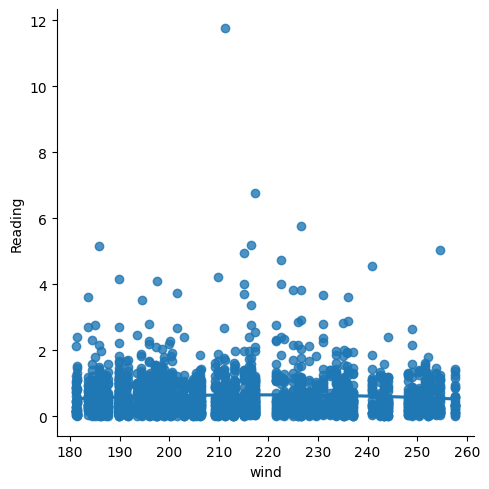

In [197]:
#Look at Roadrunner for Chlorodine readings:

road1 = aug_sensor[(aug_sensor['wind'] >= 180)&(aug_sensor['wind'] <= 260)&
                   (aug_sensor['Chemical'] == 'Chlorodinine')&
                   (aug_sensor['Reading'] >= 0)]
#sns.scatterplot(road1, x='wind',y='Reading')
sns.lmplot(x="wind", y="Reading", data=road1,order=2, ci=None)#, scatter_kws={"s": 80})

In [153]:
#sns.pairplot(sensor)
#sns.scatterplot(dec_sensor, x='date', y='wind')

In [154]:
#sns.scatterplot(data=apr_sensor, x='wind_speed', y='Reading', hue=None)
#Plot bar graph of price v. make:
#sns.barplot(x='Monitor', y="Reading", data=sensor, order=sensor['Monitor'])
#plt.set_title('Make v. Price')
#plt.set_xlabel('Make')
#plt.set_ylabel('Price')
#plt.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
#plt.show()

In [155]:
#Run regression model, after model compiled, run predictions for all and compare against actual values

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


#Split the data (70/30):
sen = sensor[sensor.Reading <= 3].copy()

X = sen.drop(columns = ['Reading', 'date'])
y = sen['Reading'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

#Encode the categorical variable (chemical):
X_train = pd.get_dummies(X_train, dtype=float)
X_test = pd.get_dummies(X_test, dtype=float)
#X_train

In [156]:
#Build a linear regression model:
reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)
#y_pred = y_pred.reshape(-1, 1)
#y_test = y_test.reshape(-1, 1)
mean_squared_error(y_test, y_pred)

0.2785987684373266

In [157]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

reg_dt = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
#cross_val_score(reg_dt, X, y, cv=10)
y_pred_dt = reg_dt.predict(X_test)
mean_squared_error(y_test, y_pred_dt)

0.3233741177300784

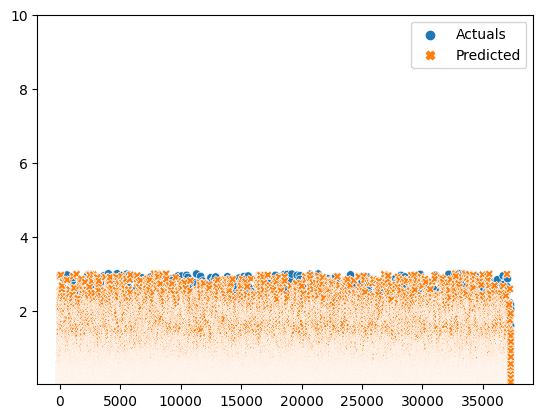

In [158]:
y_pred = reg_dt.predict(X_test)
test = pd.DataFrame(y_test.values, columns=['Actuals'])
test['Predicted'] = y_pred
sns.scatterplot(data=test)#, x='wind_speed', y='Reading', hue=None)
#test.head()
plt.ylim(bottom = .01,top=10)
plt.show()